In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import models, transforms
from src.dataset.coco import get_coco
import src.dataset.DatasetReader as DatasetReader
import matplotlib.pyplot as plt
import src.dataset.utils as utils


In [2]:
print(torch.version.cuda)  # Check CUDA version PyTorch was built with
print(torch.cuda.is_available())  # Check if PyTorch recognizes CUDA
print(torch.backends.cudnn.enabled)  # Check if cuDNN is available

print(torch.cuda.is_available())  # Should return True
print(torch.cuda.get_device_name(0))  # Should show RTX 3060


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(device)


12.6
True
True
True
NVIDIA GeForce RTX 3060 Laptop GPU
cuda


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0836544..2.2565577].


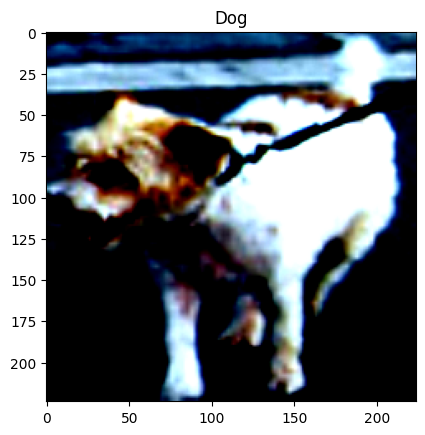

14


13

In [ ]:

transform = transforms.Compose([
    transforms.Resize((224, 224)),  
    transforms.ToTensor(),  
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  
])

dataset = DatasetReader.COCODataset(annotation_file='../data/annotations/annotations/instances_val2017.json',
    image_dir= '../data/val2017/val2017',
    target_classes=[s.lower() for s in utils.GLOBAL_CLASSES],
    transform=transform)

dataloader = DataLoader(dataset, batch_size=4, shuffle=True)

In [25]:
model = models.mobilenet_v3_small(pretrained=True)
model.classifier[3] = nn.Linear(model.classifier[3].in_features, 64)  
model = model.to(device)

#for param in model.features.parameters():
 #   param.requires_grad = False

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.00001)

def train_model(model, dataloader, criterion, optimizer, num_epochs=50):
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        for i, (images, labels) in enumerate(dataloader):

            images, labels = images.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(images)

            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            if (i + 1) % 10 == 0:
                print(f"Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(dataloader)}], Loss: {loss.item():.4f}")
        print(f"Epoch [{epoch+1}/{num_epochs}], Average Loss: {running_loss / len(dataloader):.4f}")

train_model(model, dataloader, criterion, optimizer)

c:\Users\Pro\Documents\___FAKULTET___\LPCV\LPCV_2025_T1\LPCV_2025_T1\venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Pro\Documents\___FAKULTET___\LPCV\LPCV_2025_T1\LPCV_2025_T1\venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Small_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Small_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [1/50], Step [10/5761], Loss: 4.0612
Epoch [1/50], Step [20/5761], Loss: 4.2639
Epoch [1/50], Step [30/5761], Loss: 4.0938
Epoch [1/50], Step [40/5761], Loss: 4.1358
Epoch [1/50], Step [50/5761], Loss: 4.1593
Epoch [1/50], Step [60/5761], Loss: 4.1025
Epoch [1/50], Step [70/5761], Loss: 4.2803
Epoch [1/50], Step [80/5761], Loss: 4.2308
Epoch [1/50], Step [90/5761], Loss: 4.0677
Epoch [1/50], Step [100/5761], Loss: 4.3268
Epoch [1/50], Step [110/5761], Loss: 4.0292
Epoch [1/50], Step [120/5761], Loss: 4.0939
Epoch [1/50], Step [130/5761], Loss: 4.2790
Epoch [1/50], Step [140/5761], Loss: 4.0738
Epoch [1/50], Step [150/5761], Loss: 4.1010
Epoch [1/50], Step [160/5761], Loss: 4.1687
Epoch [1/50], Step [170/5761], Loss: 4.2091
Epoch [1/50], Step [180/5761], Loss: 4.1205
Epoch [1/50], Step [190/5761], Loss: 4.0306
Epoch [1/50], Step [200/5761], Loss: 4.1727
Epoch [1/50], Step [210/5761], Loss: 4.3230
Epoch [1/50], Step [220/5761], Loss: 4.0947
Epoch [1/50], Step [230/5761], Loss: 4.23

KeyboardInterrupt: 